# P2: Investigate a Dataset

## 1. Introduction

For the second project in the Data Analyst Course from Udacity, I have chosen to do analysis on titanic dataset. This dataset is a subset of the complete data provided by [Kaggle](https://www.kaggle.com/c/titanic/data) and a description of its structure can be found there. There is information about 891 of 2224 passengers and crew on board of the Titanic.

Objective of this project is to figure out the key factors which influcenced the surivival of passengers and crew on-board. In Specific I will be performing analysis to find out:
    
   -  Whether males or females were more likely to survive?
   -  Whether social class had any influence on chances of survival?
   -  Whether a particular age group were more likely to survive?
   -  Whether families on-boards have more chances of survival?
   -  Whether there was a variation in survival rate for different decks?

## 2. Data Wrangling

Titanic Dataset is provided in csv format, there are a couple of packages that can read data from csv format. I will be using pandas package to load the data directly to a dataframe, which makes it easy for any analysis in further steps.

In addition to pandas I will also be using Numpy and Matplotlib libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
import ipy_table as tbl

%pylab inline

# Loading the dataset using pandas function read_csv
titanic_dataset = pd.read_csv('titanic_data.csv')

# Let's run a couple of commands to verify the data has been loaded correctly 
titanic_dataset.head()

Populating the interactive namespace from numpy and matplotlib


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [2]:
# Let's see what column types we have in the dataset
titanic_dataset.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Survived column is of type int, I would like to convert that to a bool which is more appropriate. Sex is a categorical variable, it would be handy to convert this to 0 and 1 for any numerical analysis that has to be done on top of it. 

In [3]:
titanic_dataset['Survived'] = titanic_dataset['Survived'].astype(bool)
titanic_dataset['Sex'] = titanic_dataset['Sex'].map({'female': 0, 'male': 1})

Let's summarize the dataset using describe function for numeric columns for descriptive stats to understand the data better.

In [4]:
titanic_dataset.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429
min,1.000000,False,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,True,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200


## 2.1 Feature Engineering

It is often important to add derived columns which can add value to our analysis. 

From visual inspection of the dataset, I was able to find there were missing values for age variable. Age is an important feature to determine the chances of survival, so it is better to update missing values with meaningful information(will be done in further steps). I was interseted to see whether title information can be derived from name column, as title information can be used as one of the factor to estimate age.

Feature variable 1: Title

In [5]:
titanic_dataset['Name'].str.replace('(.*, )|(\\..*)', '', case=False).value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Name, dtype: int64

As there are quite a few rare titles it will better if group them to a single unique title. (There cannot be much value extracted by treating these rare titles separately. To avoid complexity grouping is done.)

Let's also fix french titles (Mlle to Miss, Mme to Mrs) and short forms (Ms to Miss)

In [6]:
# Also reassign mlle, ms, and mme accordingly
titanic_dataset['Title'] = titanic_dataset['Name'].str.replace('(.*, )|(\\..*)', '', case=False)
titanic_dataset['Title'].replace('Mlle','Miss', True)
titanic_dataset['Title'].replace('Ms','Miss', True)
titanic_dataset['Title'].replace('Mme','Mrs', True)
rare_titles = ['Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']
titanic_dataset['Title'].replace(rare_titles, 'rare', True)
titanic_dataset['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
rare       23
Name: Title, dtype: int64

Let's store this information to a column 'Title', since our objective is that having title can help us deal with missing ages, it is better we map each of the variables to a unique int value to do numeric analysis in further steps.

In [7]:
titanic_dataset['Title'] = titanic_dataset['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs':2, 'Master':3, 'rare':4})

Let's move on to another derived variable!!


To do analysis on whether families have better chance of survival, we need to calculate the family size of each passenger, Forunately information about Number of siblings/spouses aboard and Number of parents/children aboard is specified for each passenger. All that is required is to sum them up to get the family size.

Feature variable 2: Family_size


In [8]:
titanic_dataset['Family_size'] = titanic_dataset['SibSp'] +titanic_dataset['Parch'] + 1
titanic_dataset['Family_size'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: Family_size, dtype: int64

As we can see from the output above we have varied number of family sizes, to make it simpler we can spilt this into 3 categories, 1) Single, 2) Small family size (under 4 members) 3) Large fammily size (greater than 4 members)

Using these variables we can make a generalized statement to whether families swim together or singles have more chance of survival

In [9]:
titanic_dataset.loc[titanic_dataset.Family_size == 1, 'Family_size_category'] = 'single'
titanic_dataset.loc[titanic_dataset.Family_size > 4, 'Family_size_category'] = 'large'
titanic_dataset.loc[(titanic_dataset.Family_size >1) & (titanic_dataset.Family_size <= 4), 'Family_size_category'] = 'small'

titanic_dataset['Family_size_category'].value_counts()

single    537
small     292
large      62
Name: Family_size_category, dtype: int64

Feature variable 3: Deck information!

I think which deck a passenger is located is a important factor of survival. Passengers on top deck can have quick and  easy access to the resuce boats on titanic. Deck information however is not provided in the titanic dataset, after dong a lil bit of research online i was able to figure out that Cabin information contains which deck a particular passenger is on. Cabin number C85 means that the passenger is on Deck C.

Let's look at how many passengers have cabin information.

In [10]:
print "Null cabin count: ",titanic_dataset["Cabin"].isnull().sum()
known_cabin_passengers = titanic_dataset.dropna(subset = ["Cabin"])
print "Passengers count: ", len(titanic_dataset)
print "Known cabin passengers count: ", len(known_cabin_passengers)

Null cabin count:  687
Passengers count:  891
Known cabin passengers count:  204


As Cabin number being a string variable and amount of data that is available to us is only 204 out of 891 records, It is not enough information to update the missing data for 687 records. 

I decided to stick doing analysis on just 204 records. I am storing this 204 records in other dataframe.

From visual inspection of the cabin numbers, I have noticed that there are passengers who are assigned to multiple cabins, some on different decks. Since, we are not sure on which deck they were during the crash. I am ignoring the rows which have two different deck information.

In [11]:
split_cabins = known_cabin_passengers["Cabin"].str.split(" ") # create a Series containing lists of cabins
split_cabins = split_cabins.apply(pd.Series, 1).stack() # split the lists in multiple rows 
split_cabins.index = split_cabins.index.droplevel(-1) # remove the extra index column
split_cabins.name = "Cabin"

del known_cabin_passengers["Cabin"] # delete the original column
known_cabin_passengers = known_cabin_passengers.join(split_cabins) # insert the new column

In [12]:
decks = known_cabin_passengers["Cabin"].str[0]
decks.name = "Deck"

cabins = known_cabin_passengers["Cabin"].str[1:]
cabins.name = "Cabin"

del known_cabin_passengers["Cabin"]
known_cabin_passengers = pd.concat([known_cabin_passengers, decks, cabins], join="inner", axis=1)

In [13]:
known_cabin_passengers.drop_duplicates(['PassengerId', 'Deck'], inplace=True) # This gets rid of same passegners with multiple same decks
known_cabin_passengers.drop_duplicates(['PassengerId'], keep=False, inplace=True) # This gets rid of same passegners with multiple different decks

In [14]:
known_cabin_passengers.Deck.value_counts()

C    59
B    47
D    33
E    32
A    15
F     9
G     4
T     1
Name: Deck, dtype: int64

In [15]:
known_cabin_passengers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 889
Data columns (total 16 columns):
PassengerId             200 non-null int64
Survived                200 non-null bool
Pclass                  200 non-null int64
Name                    200 non-null object
Sex                     200 non-null int64
Age                     182 non-null float64
SibSp                   200 non-null int64
Parch                   200 non-null int64
Ticket                  200 non-null object
Fare                    200 non-null float64
Embarked                198 non-null object
Title                   200 non-null int64
Family_size             200 non-null int64
Family_size_category    200 non-null object
Deck                    200 non-null object
Cabin                   200 non-null object
dtypes: bool(1), float64(2), int64(7), object(6)
memory usage: 25.2+ KB


## 2.2 Investigating Dataset and finding missing / incomplete data

For analysis to be meaningful, we need to have a valid dataset, It is important to take care of missing data and to check if any outliers exist in the dataset. In this dataset the only column where we can check for outliers is age, It is not feasible to check for outliers for other columns as we do not have any references to compare against.

In [16]:
# info function helps us to find the data types of the columns and also if there are any missing data for the respective columns
titanic_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 15 columns):
PassengerId             891 non-null int64
Survived                891 non-null bool
Pclass                  891 non-null int64
Name                    891 non-null object
Sex                     891 non-null int64
Age                     714 non-null float64
SibSp                   891 non-null int64
Parch                   891 non-null int64
Ticket                  891 non-null object
Fare                    891 non-null float64
Cabin                   204 non-null object
Embarked                889 non-null object
Title                   891 non-null int64
Family_size             891 non-null int64
Family_size_category    891 non-null object
dtypes: bool(1), float64(2), int64(7), object(5)
memory usage: 105.3+ KB


There are 891 rows in our dataset, from the above information we can see that the columns Age, Cabin and Embarked have missing data. We can deal with missing data in couple of ways. Simple way is to remove the rows where we have missing data which can cause to lose information which may be important, also as we are dealing with comparatively small dataset and each row corresponds to a unique person on board we cannot remove the data. Instead we try to figure out appropriate values based on mean and median for the missing data.

## 2.2.1 Update missing Ages



From the info output we see that we have information of Age for only 714 people on-board out of 891. Simplest way to calculate the ages for the rest of them would be to use group by of the parameters that effect the Age variable and then subsitutte the missing values with median of that particular group.

When we assume that there may be multiple factors that effect Age then it is better to go with Nearest Neighbours classification, as it can consider various Age affecting parameters and calculate the approximate of Age.

In [17]:
# Keeping a copy of the dataset to compare against the updated data
reference_age = titanic_dataset.loc[:,['Age']].dropna(axis=0)

In [18]:
# This function runs KNeighborsClassifier with 5 neighbours considering the variables
# 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex', 'Title', 'Family_size', 'Survived'
# First the model gets trained on the data that has no missing information of Age,
# The trained model is then used to predict values for the Age.
def executeImputeModel():
    impute_model = KNeighborsClassifier(n_neighbors=5)
    subset_col_dataset = titanic_dataset.loc[:,['Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex', 'Title', 'Family_size', 'Survived']]
    non_na_dataset = subset_col_dataset.dropna(axis=0)
    na_dataset = subset_col_dataset[subset_col_dataset['Age'].isnull()]
    impute_model.fit(non_na_dataset.ix[:, non_na_dataset.columns != 'Age'], np.asarray(non_na_dataset['Age'] , dtype="|S6"))
    imputed_age= pd.DataFrame(impute_model.predict(na_dataset.ix[:, na_dataset.columns != 'Age']), columns=['Age'])
    imputed_age.index = na_dataset.index.tolist()
    titanic_dataset.loc[imputed_age.index,imputed_age.columns] = imputed_age
    titanic_dataset['Age'] = titanic_dataset['Age'].astype(float)


In [19]:
executeImputeModel() #Running the impute function

Checking the distribution of age before and after adding the missing data. From the histogram graph we can find out whether adding the missing values did not change the distribution drastically.

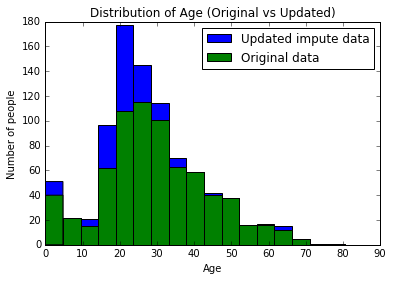

In [20]:
# Histogram to show the distribution of reference data to the updated data.
bins = np.linspace(0, 90, 20)
plt.hist(titanic_dataset['Age'], bins, label='Updated impute data')
plt.hist(reference_age['Age'], bins, label='Original data')
plt.xlabel("Age")
plt.ylabel("Number of people")
plt.title("Distribution of Age (Original vs Updated)")
plt.legend(loc='upper right')
plt.show()

As, it is observed from the graph above, adding age did not change the distribution very much.

From the graph above the we dont have any outliers for age, We can verify that with Describe command

In [21]:
titanic_dataset.Age.describe()

count    891.000000
mean      28.121134
std       14.043244
min        0.420000
25%       19.000000
50%       26.000000
75%       35.500000
max       80.000000
Name: Age, dtype: float64

Age data is under acceptable range.  ( It is unlikely to have age less than 0 and greater than 100 )

## 2.3 Data Exploration

Let's see the overview of passengers that have survived and deceased.

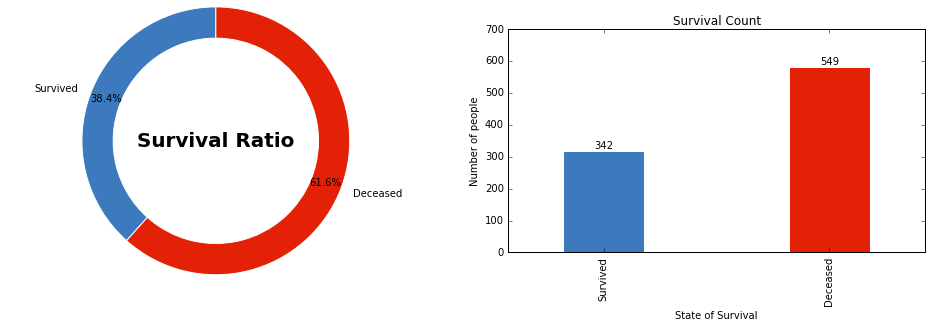

In [22]:
#This function makes a plot of 2 subplots (donut graph to show percents and bar graph to show counts)
def make_bar_pie(text,labels):
    colors = [(60,121,189),(226,33,7)]
    col = [[i/255. for i in c] for c in colors]
    
    #donut graph
    ax = plt.subplot(1,2,1)
    ax.axis('equal')
    sizes = [titanic_dataset[titanic_dataset.Survived == True].shape[0], titanic_dataset[titanic_dataset.Survived == False].shape[0]]
    width = 0.35
    kwargs = dict(colors=col, startangle=90, autopct='%1.1f%%')
    outside = ax.pie(sizes, radius=1.5, pctdistance=1.05-width/2, labels=labels,**kwargs)[0]
    plt.setp( outside, width=width, edgecolor='white')

    kwargs = dict(size=20, fontweight='bold', va='center')
    ax.text(0, 0, text, ha='center', **kwargs)
    
    # Bar graph
    plt.subplot(1,2,2)
    plt.subplots_adjust(left=0.125, right= 2.25)
    var = titanic_dataset.groupby('Sex').Survived.count()
    ax1 = var.plot(kind='bar', width=0.35)
    ax1.set_title('Survival Count')
    ax1.set_ylabel('Number of people')
    ax1.set_xticklabels(labels)
    ax1.set_xlabel("State of Survival")
    plt.ylim([0, 700])
    rects = ax1.patches
    # Now make some labels
    labels = sizes
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    for child, c in zip(ax1.get_children(), col):
        child.set_color(c) 
    plt.show()

    

# Calling the function to plot the graphs
make_bar_pie("Survival Ratio",['Survived','Deceased'])

From the graphs above,

    Survived = 38.4% of 891 people on board have survived = 342
    Deceased = 61.6% of 891 people on board have deceased = 549

### Whether males or females were more likely to survive?

Let's visualize the data to get a better sense of the question that is posed. The following code generates 3 graphs, 1) Bar graph that shows the counts 2) pie graph shows ratio Survived vs Deceased 3) another pie to show ratio Males vs Females

In [23]:
# creating extra variables for graphs
total_survived = titanic_dataset[titanic_dataset.Survived == True] 
male_survived = total_survived[total_survived.Sex == 1].shape[0]
female_survived = total_survived[total_survived.Sex == 0].shape[0]

total_deceased = titanic_dataset[titanic_dataset.Survived == False]
male_deceased = total_deceased[total_deceased.Sex == 1].shape[0]
female_deceased = total_deceased[total_deceased.Sex == 0].shape[0]

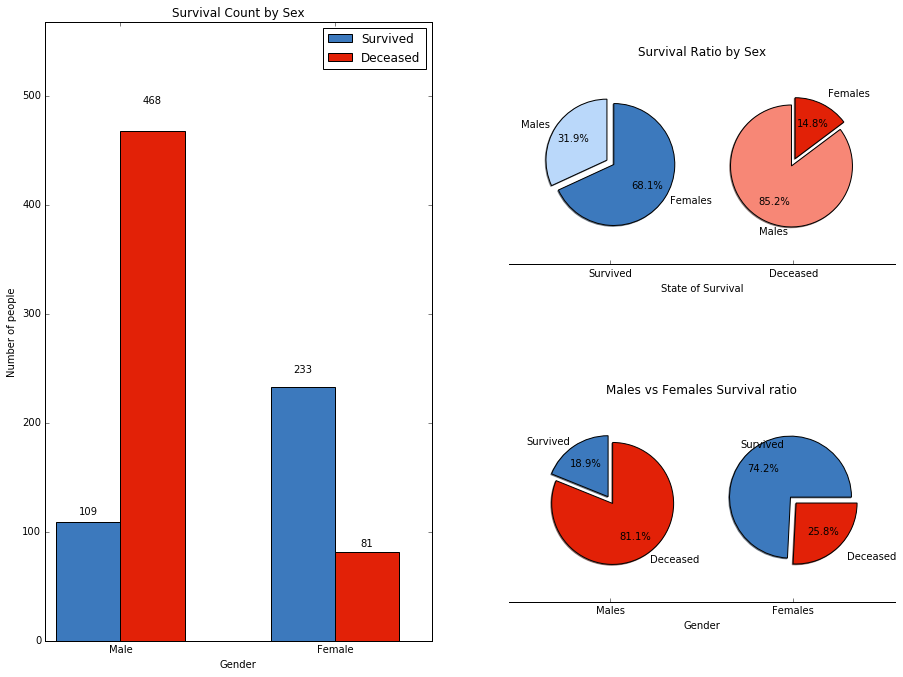

In [24]:
survived_count = (male_survived, female_survived)
deceased_count = (male_deceased, female_deceased)

males_count = (male_survived, male_deceased)
females_count = (female_survived, female_deceased)

fig = plt.figure(figsize=(8, 8)) 
gs = plt.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1,1])  # Using Grid Spec to split the graph space for 3 graphs
ind = np.arange(2)  # the x locations for the groups
width = 0.30       # the width of the bars

colors = [(60,121,189),(226,33,7)]
col = [[i/255. for i in c] for c in colors]
# Bar Graph
ax = plt.subplot(gs[0:, 0])
rects1 = ax.bar(ind+0.25, survived_count, width, color=col[0])
rects2 = ax.bar(ind + width + 0.25, deceased_count, width, color=col[1])

# add some text for labels, title and axes ticks
ax.set_ylabel('Number of people')
ax.set_title('Survival Count by Sex')
ax.set_xticks(ind + width + 0.25)
ax.set_xticklabels(('Male', 'Female'))
ax.legend((rects1[0], rects2[0]), ('Survived', 'Deceased'))
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
plt.ylim([0, max(list(survived_count)+ list(deceased_count))+100])
ax.set_xlabel("Gender")


# Pie Graph 1
ax1 = plt.subplot(gs[0,1])
plt.subplots_adjust(left=0.525, right= 2, top=1.2)
labels = 'Males', 'Females'
s_colors_rgb = [(186,216,250), (60,121,189)]
s_col = [[i/255. for i in c] for c in s_colors_rgb]
d_colors_rgb = [(247,135,118),(226,33,7)]
d_col = [[i/255. for i in c] for c in d_colors_rgb]
explode = (0.1, 0.1)
ax1.pie(survived_count, explode=explode, labels=labels, colors=s_col,
       autopct='%1.1f%%', shadow=True, startangle=90,
       radius=1.5, center=(0, 0), frame=True, pctdistance=0.65)
ax1.pie(deceased_count, explode=explode, labels=labels, colors=d_col,
       autopct='%1.1f%%', shadow=True, startangle=90,
       radius=1.5, center=(4.5, 0), frame=True, pctdistance=0.65, labeldistance=1.2)
ax1.set_xticks([0, 4.5])
ax1.set_yticks([])
ax1.set_xticklabels(["Survived", "Deceased"])
ax1.set_yticklabels([""])
ax1.set_xlim((-2.5, 7))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().tick_bottom()
ax1.set_ylim((-2.5, 2.5))
ax1.set_title('Survival Ratio by Sex')
ax1.set_xlabel("State of Survival")
# Set aspect ratio to be equal so that pie is drawn as a circle.
ax1.set_aspect('equal')

# Pie Graph 2
ax2 = plt.subplot(gs[1, 1])
labels = 'Survived', 'Deceased'

ax2.pie(males_count, explode=explode, labels=labels, colors=col,
       autopct='%1.1f%%', shadow=True, startangle=90,
       radius=1.5, center=(0, 0), frame=True, pctdistance=0.65)
ax2.pie(females_count, explode=explode, labels=labels, colors=col,
       autopct='%1.1f%%', shadow=True, startangle=0,
       radius=1.5, center=(4.5, 0), frame=True, pctdistance=0.65, labeldistance=1.2)

ax2.set_xticks([0, 4.5])
ax2.set_yticks([])
ax2.set_xticklabels(["Males", "Females"])
ax2.set_yticklabels([""])
ax2.set_xlim((-2.5, 7))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().tick_bottom()
ax2.set_ylim((-2.5, 2.5))
ax2.set_title('Males vs Females Survival ratio')
# Set aspect ratio to be equal so that pie is drawn as a circle.
ax2.set_aspect('equal')
ax2.set_xlabel("Gender")
plt.show()

1) The Bar Graph shows that there are more male passengers than female passengers, It also tells that more females have survived than males.

2) The top pie graph shows us that out 100% survived there are only about 31.9% of males and the rest of 68.1% are females.

3) The bottom pie graph shows us that out 100% of male passengers 18.9% have survived contrary to 74.2% of females survived in 100% of females.

From the graphs above it is a clear indication that females had far better chance of survival than males. To find out if the difference is significant we have to do hypothesis testing.

##### Hypothesis
H0 = Males and Females have equal chance of survival

HA = Males and Females do not have equal chance of survival

To tackle this we can use Chi-Square test to find if the survival and sex are independent of each other, If the probability is high which means that the difference which we have seen in the graph is just due to chance. If proabability is very low then the sex and survival are dependent which means either of the gender has higher chances of survival.

In [25]:
# We can use the chi2_contingency function to calculate the chi square value
# the variable survived_count is a list of males survived and females survived
# the variable deceased_count is a list of males deceased and females deceased.
chi2, p, dof, expected = stats.chi2_contingency([survived_count,deceased_count])
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,260.7170
P-Value,0.0000


We see from the table above that the P-Value is 0.0000 which is significant at alpha level = 0.01, 

###### Hence we reject the Null Hypothesis in favor of Alternative Hypothesis.  Therefore Gender and Survival are dependent variables, from the graphs we can conclude that Females have higher chances of survival.

### Whether social class had any influence on chances of survival?

Let's visualize the data to get a better sense of the question that is posed. The following code generates 3 graphs, 1) Bar graph that shows the counts 2) pie graph shows ratio Survived vs Deceased 3) another pie to show ratio PClass 1 vs 2 vs 3

In [26]:
# creating extra variables for graphs
total_survived = titanic_dataset[titanic_dataset.Survived == True]
p1_survived = total_survived[total_survived.Pclass == 1].shape[0]
p2_survived = total_survived[total_survived.Pclass == 2].shape[0]
p3_survived = total_survived[total_survived.Pclass == 3].shape[0]

total_deceased = titanic_dataset[titanic_dataset.Survived == False]
p1_deceased = total_deceased[total_deceased.Pclass == 1].shape[0]
p2_deceased = total_deceased[total_deceased.Pclass == 2].shape[0]
p3_deceased = total_deceased[total_deceased.Pclass == 3].shape[0]

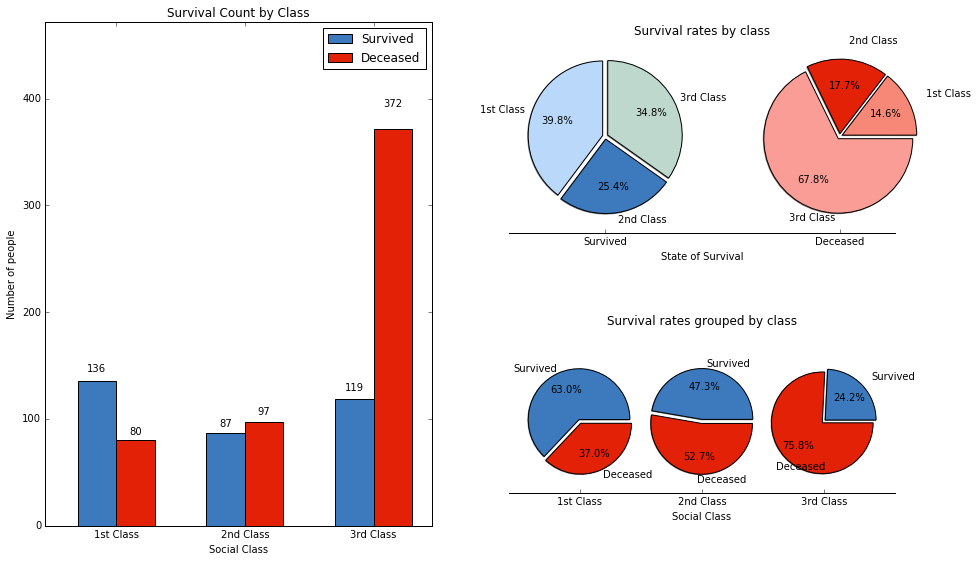

In [27]:
survived_count = (p1_survived, p2_survived, p3_survived)
deceased_count = (p1_deceased, p2_deceased, p3_deceased)

p1_count = (p1_survived, p1_deceased)
p2_count = (p2_survived, p2_deceased)
p3_count = (p3_survived, p3_deceased)

fig = plt.figure(figsize=(8, 8)) 
gs = plt.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1,1]) # Using Grid Spec to split the graph space for 3 graphs
ind = np.arange(3)  # the x locations for the groups
width = 0.30       # the width of the bars
colors = [(60,121,189),(226,33,7)]
col = [[i/255. for i in c] for c in colors]
#Bar Graph    
ax = plt.subplot(gs[0:, 0])
rects1 = ax.bar(ind+0.25, survived_count, width, color=col[0])
rects2 = ax.bar(ind + width + 0.25, deceased_count, width, color=col[1])
# add some text for labels, title and axes ticks
ax.set_ylabel('Number of people')
ax.set_title('Survival Count by Class')
ax.set_xticks(ind + width + 0.25)
ax.set_xticklabels(('1st Class', '2nd Class', '3rd Class'))
ax.legend((rects1[0], rects2[0]), ('Survived', 'Deceased'), loc='best')
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
plt.ylim([0, max(list(survived_count)+ list(deceased_count))+100])
ax.set_xlabel("Social Class")

# Pie Grpah 1
ax1 = plt.subplot(gs[0,1])
plt.subplots_adjust(left=0.525, right= 2, top=1.0)
labels = '1st Class', '2nd Class', '3rd Class'
s_colors_rgb = [(186,216,250), (60,121,189), (190,216,206) ]
s_col = [[i/255. for i in c] for c in s_colors_rgb]
d_colors_rgb = [(247,135,118),(226,33,7), (250,157,150)]
d_col = [[i/255. for i in c] for c in d_colors_rgb]
explode = (0.1, 0.1, 0.1)
ax1.pie(survived_count, explode=explode, labels=labels, colors=s_col,
       autopct='%1.1f%%', shadow=True, startangle=90,
       radius=2.7, center=(0, 0), frame=True, pctdistance=0.65)
ax1.pie(deceased_count, explode=explode, labels=labels, colors=d_col,
       autopct='%1.1f%%', shadow=True, startangle=0,
       radius=2.7, center=(8.5, 0), frame=True, pctdistance=0.65, labeldistance=1.25)
ax1.set_xticks([0, 8.5])
ax1.set_yticks([])
ax1.set_xticklabels(["Survived", "Deceased"])
ax1.set_yticklabels([""])
ax1.set_xlim((-3.5, 10.5))
ax1.set_ylim((-3.5, 3.5))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.get_xaxis().tick_bottom()
ax1.set_title('Survival rates by class')
ax1.set_xlabel("State of Survival")
# Set aspect ratio to be equal so that pie is drawn as a circle.
ax1.set_aspect('equal')

# Pie Graph 2
ax2 = plt.subplot(gs[1, 1])
labels = 'Survived', 'Deceased'
s_colors_rgb = [(186,216,250), (60,121,189), (190,216,206) ]
s_col = [[i/255. for i in c] for c in s_colors_rgb]
d_colors_rgb = [(247,135,118),(226,33,7), (250,157,150)]
d_col = [[i/255. for i in c] for c in d_colors_rgb]
explode = (0.1, 0.1)
ax2.pie(p1_count, explode=explode, labels=labels, colors=col,
       autopct='%1.1f%%', shadow=True, startangle=0,
       radius=2.5, center=(0, 0), frame=True, pctdistance=0.65)
ax2.pie(p2_count, explode=explode, labels=labels, colors=col,
       autopct='%1.1f%%', shadow=True, startangle=0,
       radius=2.5, center=(6, 0), frame=True, pctdistance=0.65)
ax2.pie(p3_count, explode=explode, labels=labels, colors=col,
       autopct='%1.1f%%', shadow=True, startangle=0,
       radius=2.5, center=(12, 0), frame=True, pctdistance=0.65, labeldistance=1.25)
ax2.set_xticks([0, 6, 12])
ax2.set_yticks([])
ax2.set_xticklabels(['1st Class', '2nd Class', '3rd Class'])
ax2.set_yticklabels([""])
ax2.set_xlim((-3.5, 15.5))
ax2.set_ylim((-3.5, 4.5))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_xaxis().tick_bottom()
ax2.set_xlabel("Social Class")
ax2.set_title('Survival rates grouped by class')
# Set aspect ratio to be equal so that pie is drawn as a circle.
ax2.set_aspect('equal')

# Display graphs
plt.show()

1) The Bar Graph shows that there are more 3rd classs passengers than 1st class and 2nd class, It also tells that more 3rd class passengers are deceased than other two classes.

2) The top pie graph shows us that out 100% survived there are about 39.8% of 1st class, 34.8% of second class and the rest of 25.4% are 3rd class. These are approximately same but 100% deceased graph clearly show that 67.8% of 3rd class people are deceased.

3) The bottom 3 pie graphs show declined rate of survivability as we move from 1st class to 3rd class.

From the graphs above it is a clear indication that 1st class had better chance of survival than 2nd class and 3rd class, 2nd class had better chances of survival over 3rd class. To find out if the difference is significant we have to do hypothesis testing.

##### Hypothesis
H0 = All Social Class have equal chance of survival

HA = All Social Class do not have equal chance of survival

To tackle this we can use Chi-Square test to find if the survival and social class are independent of each other.

In [28]:
chi2, p, dof, expected = stats.chi2_contingency([survived_count,deceased_count])
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,102.8890
P-Value,0.0000


We see from the table above that the P-Value is 0.0000 which is significant at alpha level = 0.01, 

###### Hence we reject the Null Hypothesis in favor of Alternative Hypothesis.  Therefore Social Class and Survival are dependent variables, from the graphs we can conclude that 1st class passengers have higher chances of survival.

### Whether a particular age group were more likely to survive?

As age is a numeric variable unlike sex and social class, approach to this problem will be based on distribution of age.To find out if age and survival are independent variables we have to split the age into bins and assign each bin with a label, these labels can then be compared with survived variable to see whether we have some bins which are more likely to survive.


In [29]:
# This function creates bins and assigns to thier respective age label based on the binsize
# function returns age_labels variable which is list of all distinct age groups
# age_label will be used by build_age_group_graph function to plot graphs.
def create_bins(binsize):
    age_labels = []
    end_age_array = [0]
    max_age = max(titanic_dataset.Age)
    min_age = 1
    start_age = 0
    end_age = -1
    num_bins = int (ceil(((ceil(float(max_age/10.0)))*10) / binsize))
    for i in range(num_bins):
        start_age = end_age + 1
        end_age = start_age + binsize - 1
        age_labels.append(str(start_age)+"-"+str(end_age))
        end_age_array.append(end_age)
    titanic_dataset['age_group'] = pd.cut(titanic_dataset.Age, range(0, int(ceil(float(max(titanic_dataset.Age)) / binsize) *binsize) + 1, binsize), right=False, labels=age_labels)
    return age_labels

In [30]:
# This function takes the age_labels variable generated from create_bins functions and creates two bar graphs
# first bar graph shows the count and second shows the percentage
def build_age_group_graph(age_labels):    
    survivors_data = titanic_dataset[titanic_dataset.Survived==True]
    non_survivors_data = titanic_dataset[titanic_dataset.Survived==False]
    # calculate values for each survival status
    survivors_age_group = survivors_data.groupby(['age_group']).size().values
    non_survivors_age_group = non_survivors_data.groupby(['age_group']).size().values
    # calculate totals for percentates
    totals = survivors_age_group + non_survivors_age_group
    
    # use calculate_percentage_function to calculate percentage of the total
    data1_percentages = np.true_divide(survivors_age_group,totals) * 100
    data2_percentages = np.true_divide(non_survivors_age_group,totals) * 100
    
    tick_spacing = np.array(range(int(titanic_dataset.age_group.value_counts().shape[0])))+0.4
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    # plot chart for count of survivors by class
    ax1.bar(range(len(survivors_age_group)), survivors_age_group, label='Survivors',color=col[0])
    ax1.bar(range(len(non_survivors_age_group)), non_survivors_age_group, bottom=survivors_age_group, label='Non-Survivors', color=col[1])
    plt.sca(ax1)
    plt.xticks(tick_spacing, age_labels )
    ax1.set_ylabel("Count")
    ax1.set_xlabel("Age group")
    ax1.set_title("Count of survivors by age group",fontsize=14)
    plt.legend(loc='upper right')
    
    # plot chart for percentage of survivors by class
    ax2.bar(range(len(data1_percentages)), data1_percentages, color=col[0])
    ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, color=col[1])
    plt.sca(ax2)
    plt.xticks(tick_spacing,  age_labels)
    ax2.set_ylabel("Percentage")
    ax2.set_xlabel("Age group")
    ax2.set_title("% of survivors by age group",fontsize=14)

In [31]:
# Function calculates the chi square value and p-value which returned as a table.
def calculate_chi_square_for_age():
    table = pd.crosstab([titanic_dataset['Survived']], titanic_dataset['age_group'])
    chi2, p, dof, expected = stats.chi2_contingency(table.values)
    results = [
        ['Item','Value'],
        ['Chi-Square Test',chi2],
        ['P-Value', p]
    ]
    return tbl.make_table(results)

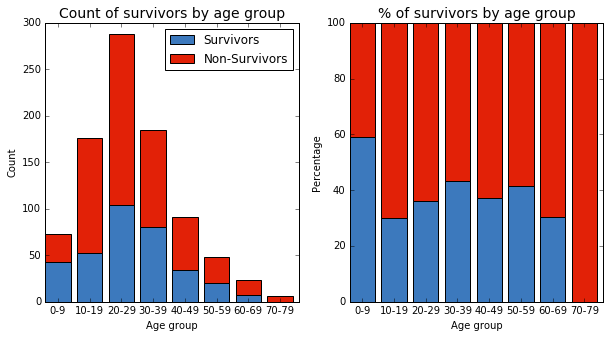

In [32]:
build_age_group_graph(create_bins(10)) # Let's visualize the data for bin size of 10

1) From the graphs above we can see that there are more passengers in the age group 20-29

2) % Survived is max for the age group 0-9 (Makes sense because kids might have given more preference when boarding the life boats)

Let's do hypothesis testing to see if the difference is just due to chance or there is dependency of age group on survival

##### Hypothesis
H0 = All Age groups have equal chance of survival

HA = All Age groups do not have equal chance of survival

To tackle this we can use Chi-Square test to find if the survival and Age_group are independent of each other.

In [33]:
calculate_chi_square_for_age() # Calling the function to calculate the chisqaure and pvalue

Item,Value
Chi-Square Test,25.1894
P-Value,0.0007


We see from the table above that the P-Value is 0.0007 which is significant at alpha level = 0.01, 

###### Hence we reject the Null Hypothesis in favor of Alternative Hypothesis. For binsize of 10 we have significant between chances of survival for each group, Group that is most likely to survive is 0-9 age group.

But this cannot mean that Age and Survival rates have siginficant relationship for all bin sizes, Lets look at bin size 20 and comment on the hypothesis test again.

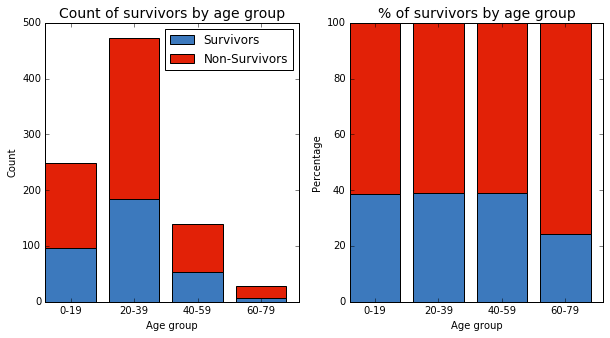

In [34]:
build_age_group_graph(create_bins(20))

From the 2nd bar graph above we can see for bin size 20 all the groups have same chances of survival, Let's confirm this using Chi Square test.

In [35]:
calculate_chi_square_for_age() # Calling the function to calculate the chisqaure and pvalue

Item,Value
Chi-Square Test,2.5576
P-Value,0.4650


We see from the table above that the P-Value is 0.4650 which is not significant at alpha level = 0.05.

###### Hence we cannot reject the Null Hypothesis. For binsize of 20 all age groups have equal chances of survival.

Our Objective of the question is to find if there are any particular age group that had more chances of survival, From the tests conducted above we see that binsize plays a crucial role to answer if this is just by chance or if there was preference given for particular age group.

The function that we coded above to create bins start from 0, this will be limitiation. Let's assume the age group that most chance of survival is 8-17, but from the function we only get groups 0-9 and 10-19 with window size 10. So, we need to create a sliding binsize concept that looks at the best consecutive age groups based on binsize. 

with bin size 3 for ages 0-5 we get 4 groups as shown below

    G1               G2               G3               G4
    [0 1 2] 3 4 5    0 [1 2 3] 4 5    0 1 [2 3 4] 5    0 1 2 [3 4 5]
We now compare which group has the max percent of survival.

The function below calculates the best age group which has highest chance of survival for various binsizes.

In [36]:
from itertools import tee, izip

def window(iterable, size):
    iters = tee(iterable, size)
    for i in xrange(1, size):
        for each in iters[i:]:
            next(each, None)
    return izip(*iters)
for window_size in [30,25,20,15,10,5,3,2]:
    percent_survived_list = []
    temp_value = []
    for each in window(xrange(int(max(titanic_dataset.Age))), window_size):
        test = titanic_dataset[titanic_dataset.Age.between(min(each), max(each), inclusive=True)]
        survivors_data = test[test.Survived==True]
        non_survivors_data = test[test.Survived==False]
        key_string = str(str(min(each))+"-"+str(max(each)))
        try:
            total = int(survivors_data.shape[0] + non_survivors_data.shape[0])
            percent_survived = float(survivors_data.shape[0])/total
            value = [{key_string: [{"total": total}, {"percent_survived":percent_survived}]}]
            percent_survived_list.append(percent_survived)
            temp_value.append(value)
        except:
            percent_survived_list.append(float(0))
            value = [{key_string: [{"total": total}, {"percent_survived":0}]}]
            temp_value.append(value)
            
    max_range_age = temp_value[percent_survived_list.index(max(percent_survived_list))][0]
    
    print "for Bin Size: "+str(window_size)+", Range: "+str(max_range_age.keys()[0]) + ", total num of passengers/crew in this range of age group: " + str(max_range_age.values()[0][0]["total"]) + ", of which " + str(round(max_range_age.values()[0][1]["percent_survived"] *100, 2) ) +"% have survived"  

for Bin Size: 30, Range: 31-60, total num of passengers/crew in this range of age group: 295, of which 42.37% have survived
for Bin Size: 25, Range: 31-55, total num of passengers/crew in this range of age group: 277, of which 42.6% have survived
for Bin Size: 20, Range: 48-67, total num of passengers/crew in this range of age group: 86, of which 43.02% have survived
for Bin Size: 15, Range: 0-14, total num of passengers/crew in this range of age group: 94, of which 55.32% have survived
for Bin Size: 10, Range: 0-9, total num of passengers/crew in this range of age group: 73, of which 58.9% have survived
for Bin Size: 5, Range: 3-7, total num of passengers/crew in this range of age group: 30, of which 70.0% have survived
for Bin Size: 3, Range: 3-5, total num of passengers/crew in this range of age group: 24, of which 75.0% have survived
for Bin Size: 2, Range: 12-13, total num of passengers/crew in this range of age group: 5, of which 100.0% have survived


From the output above we can see which age group has the max survival percentage for each window size. For binsize of 15 we can see that 0-14 age group has the highest rate of survival, which also suggests that kids were given preference when boarding the life boats.

### Whether families on-boards have more chances of survival?

For this particular question we are going to look at how survival chance varies for singles to Small families to Large families. Let's see the count of passengers across 3 categories and visualize data in the graph below.

In [37]:
table = pd.crosstab(titanic_dataset['Family_size_category'],titanic_dataset['Survived'], margins=True)
table

Survived,False,True,All
Family_size_category,,,
large,52,10,62
single,374,163,537
small,123,169,292
All,549,342,891


In [38]:
# This function is just used to produce detailed lables for the mosaic graph
def return_label_mosaic(k):
    family_size_category = k[0]
    survived_count = table.loc[[k[0]], True].values[0]
    dead_count = table.loc[[k[0]], False].values[0]
    all_family_count = table.loc[[k[0]], 'All'].values[0]
    percent_survived = round ((float(survived_count)/float(all_family_count))*100.0, 2)
    percent_dead = 100 - percent_survived
    return_label = ''
    family_tmp = '' if k[0] == 'single' else ' familes'
    survived_tmp_string = ' Survived ' if k[1] == 'True' else ' Dead '
    count = survived_count if k[1] == 'True' else dead_count
    percent = percent_survived if k[1] == 'True' else percent_dead
    return_label = str(count) + survived_tmp_string + 'out of ' + str(all_family_count) + '\n' + str(percent) + '% of ' + k[0] + family_tmp+ survived_tmp_string
    return return_label

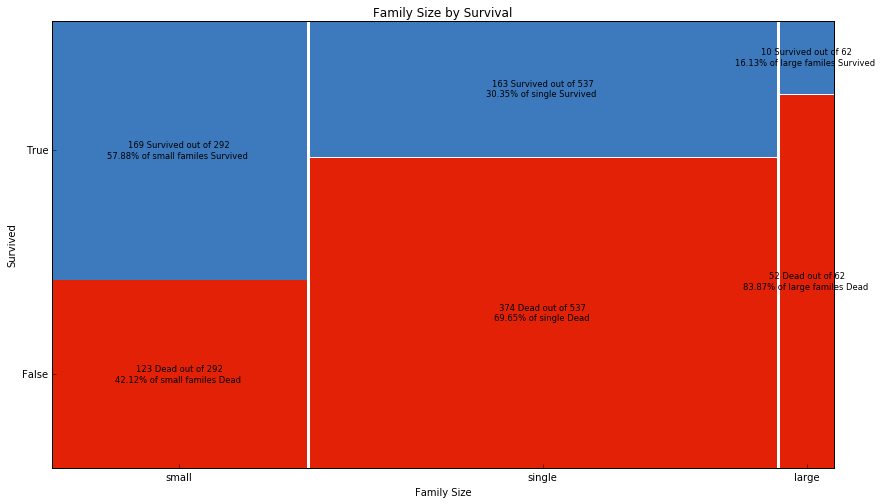

In [39]:
from statsmodels.graphics.mosaicplot import mosaic

# Mosaic graph
fig = plt.figure(figsize=(14, 8))
ax = plt.subplot()
props = lambda key: {'color': col[1] if key[1] == 'False' else col[0]}
labelizer = lambda k : return_label_mosaic(k)
ax.set_xlabel("Family Size")
ax.set_ylabel("Survived")
graph = mosaic(titanic_dataset, ['Family_size_category', 'Survived'], ax=ax ,properties= props, labelizer=labelizer,title='Family Size by Survival')


The above graph shows the information grouped by family size, out of 100% of small families 42.12% of them are dead.

Key point to observer from the graph above is Small family has 57.88% chances of survival, followed by Singles with 30.35% and large families with 16.13%

Psurvival(Small families) > Psurvival(Single) > Psurvival(Large families)

Let's do hypothesis testing to see if the difference is just due to chance or there is dependency of family size on survival

##### Hypothesis
H0 = All family size have equal chance of survival

HA = All family size do not have equal chance of survival

To tackle this we can use Chi-Square test to find if the survival and family size are independent of each other.

In [40]:
table = table.ix[[0,1,2], table.columns != 'All']
table

Survived,False,True
Family_size_category,,
large,52,10
single,374,163
small,123,169


In [41]:
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,74.5372
P-Value,0.0000


We see from the table above that the P-Value is 0.0000 which is significant at alpha level = 0.01, 

###### Hence we reject the Null Hypothesis in favor of Alternative Hypothesis. Therefore Family Size and Survival are dependent variables, from the graphs we can conclude that small families have higher chances of survival.

### Whether there was a variation in survival rate for different decks?

For this particular question we are going to look at how survival chance varies for passengers on different. Let's see the count of passengers across 3 categories and visualize data in the graph below.

This is interesting because lifeboats on titanic are more accessible by top decks on titanic. Also, we do not have information of decks for all the passengers in dataset, which means our analysis is restricted to the data that is available to us.

In [42]:
table = pd.crosstab(known_cabin_passengers['Deck'],known_cabin_passengers['Survived'])
table

Survived,False,True
Deck,,
A,8,7
B,12,35
C,24,35
D,8,25
E,8,24
F,2,7
G,2,2
T,1,0


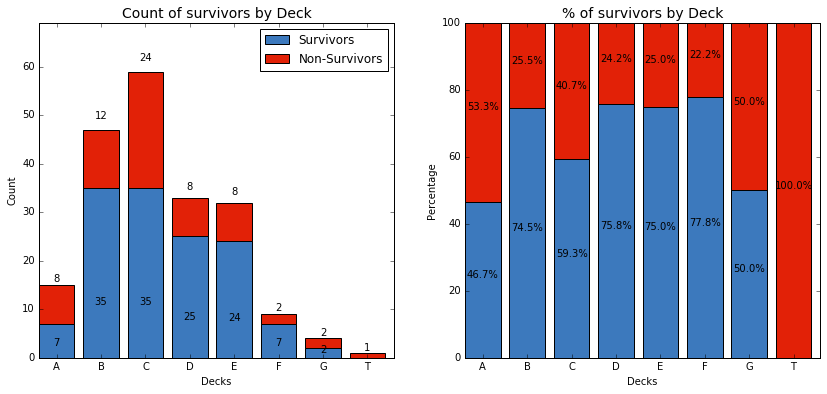

In [43]:
# calculate values for each survival decks
survivors_deck_group = table[True].values
non_survivors_deck_group = table[False].values
# calculate totals for percentates
totals = survivors_deck_group + non_survivors_deck_group 
# use calculate_percentage_function to calculate percentage of the total
data1_percentages = np.true_divide(survivors_deck_group,totals) * 100
data2_percentages = np.true_divide(non_survivors_deck_group,totals) * 100
    
tick_spacing = np.array(range(int(table.shape[0])))+0.4
deck_lables = table.index.values
# Bar graph 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
# plot chart for count of survivors by decks
rects1_1 = ax1.bar(range(len(survivors_deck_group)), survivors_deck_group, label='Survivors',color=col[0])
rects2_1 = ax1.bar(range(len(non_survivors_deck_group)), non_survivors_deck_group, bottom=survivors_deck_group, label='Non-Survivors', color=col[1])
plt.sca(ax1)
plt.xticks(tick_spacing, deck_lables )
ax1.set_ylabel("Count")
ax1.set_xlabel("Decks")
ax1.set_title("Count of survivors by Deck",fontsize=14)
plt.legend(loc='best')
plt.ylim([0, max(totals) + 10])
def autolabel(rects):
    # attach some text labels
    for rect1, rect2 in rects:
        height1 = rect1.get_height()
        height2 = rect2.get_height()
        if height1 != 0:
            ax1.text(rect1.get_x() + rect1.get_width()/2., 0.3*height1,
                    '%d' % int(height1),
                    ha='center', va='bottom')
        ax1.text(rect2.get_x() + rect2.get_width()/2., 1.05*height1 + height2,
                '%d' % int(height2),
                ha='center', va='bottom')
autolabel(zip(rects1_1, rects2_1))

# Bar graph 2
# plot chart for percentage of survivors by decks
rects1_2 = ax2.bar(range(len(data1_percentages)), data1_percentages, color=col[0])
rects2_2 = ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, color=col[1])
plt.sca(ax2)
plt.xticks(tick_spacing,  deck_lables)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("Decks")
ax2.set_title("% of survivors by Deck",fontsize=14)

def autolabel(rects):
    # attach some text labels
    for rect1, rect2 in rects:
        height1 = rect1.get_height()
        height2 = rect2.get_height()
        if height1 != 0:
            ax2.text(rect1.get_x() + rect1.get_width()/2., 0.5*height1,
                    str(round(height1,1))+'%',
                    ha='center', va='bottom')
        ax2.text(rect2.get_x() + rect2.get_width()/2., height1 + 0.5* height2,
                str(round(height2,1))+'%',
                ha='center', va='bottom')

autolabel(zip(rects1_2, rects2_2))

The bar graph on the left shows the count of survivors and deceased, The bar graph on right shows the percent of survivors across various decks.

From the graphs, it is a clear indication that all decks have approximately equal chances of survival.

##### Hypothesis
H0 = All Decks have equal chance of survival

HA = All Decks do not have equal chance of survival

To tackle this we can use Chi-Square test to find if the survival and Decks are independent of each other.

In [44]:
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,10.7216
P-Value,0.1512


We see from the table above that the P-Value is 0.1512 which is not significant at alpha level = 0.05.

###### Hence we cannot reject the Null Hypothesis. All decks have equal chances of survival.


### Of all the variables that we have looked at which are the most important features?

Using ensemble methods such as random forest, we can find out the order of importance of the features.

Feature ranking:
1. feature 2 (0.409957) Age
2. feature 0 (0.358137) Sex
3. feature 1 (0.137229) Pclass
4. feature 3 (0.094678) Family_size


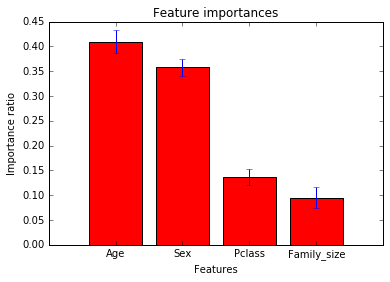

In [45]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 4 informative features
X = titanic_dataset.loc[:,['Sex', 'Pclass', 'Age', 'Family_size']]
y = titanic_dataset['Survived']

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=500,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], X.columns.values[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns.values[indices])
plt.xlabel("Features")
plt.ylabel("Importance ratio")
plt.xlim([-1, X.shape[1]])
plt.show()

From the graph above the we can see that Age is more important feature.

## 3. Conclusion

#### Limitations

The are a number of limitations with the Titanic Dataset, which are caused by:

- missing data
- only been a sample of the data
- additional information

The missing data and size of the sample could skew the results. There is missing data for Age column, for which KNearest Neighbour algorithm has been used, this is better than using mean values but it is not as good as having actual data for the analysis. There are only 200 records with valid cabin information, updating the information for rest 691 rows will skew the results and this will not be a good representation of overall dataset.

The analysis that has been done is on a sample dataset, which implies chances of having sampling error. In the analysis presented Females had better chances of survival, which may be due to bias in our sample. It's better to have analysis done on multiple samples to eliminate the possibility of sampling error and produce concrete results. Much better option would be doing analysis on complete dataset. 

It would have been nice to have the information on how people have survived, whether they were on a life boat or rescued by some other ship. Information on people being in which lifeboat can help us understand who were given more priority.


#### Summary
The major findings of this analysis are the following:

- Females (74.2%) had a way higher rate of survival than males (18.9%).

- Passengers of 1st class had 63% and 3rd class has 24.2% of survival.

- Although Age is found out to be most important feature, to comment if some age group is more likely to survive is dependent on the bin size. For bin size of 10, 0-9 age group is more likely to survive.

- It is found out that small families have more chance of survival at 57.88%.

- Data about *Decks* is unreliable, From the data that is available it is found out that All decks have equal chance of survival.

From the Random forest algorithm most important features are listed in order below:

1. Age
2. Sex
3. Pclass
4. Family_size

These variables show dependency on Survived variable, this doesn't represent a casual relationship as there may be many lurking variables effecting the chance of survival. Also, this is not a controlled to experiment to state that this relationship is due to causality.